# Modflow-setup demonstration
[Modflow-setup](https://github.com/DOI-USGS/modflow-setup) is a python package for rapid, automated construction of MODFLOW models. Often in modeling projects, construction of the basic model structure (discretization, boundary conditions, etc) consumes a lot of time that could be spent on effective history matching, uncertainty quantification and forecast scenario development. Modflow-setup aims to speed up construction of the base model in a way that is robust and repeatable. Grid-independent source data such as shapefiles and rasters are specified in a single configuration file, along with the desired packages and their options. Modflow-setup reads the configuration and the source data, and within a few minutes, produces an external array-based MODFLOW model that is amenable to parameter estimation and uncertainty quantification using PEST (e.g. [White et al, 2021](https://doi.org/10.1016/j.envsoft.2021.105022)). Detailed description of Modflow-setup is provided by [Leaf and Fienen (2022)](https://www.frontiersin.org/articles/10.3389/feart.2022.903965) and in [online documentation](https://doi-usgs.github.io/modflow-setup/latest/).

#### Example problem
Here we demonstrate Modflow-setup with a simplified version of the Pleasant Lake model published by Fienen et al (2022), who used a multi-scale modeling approach to evaluate the effects of agricultural groundwater abstraction on the ecology of Pleasant Lake in central Wisconsin, USA. The original report and model files are available at the links below. Figure 1 shows the original published model, which included a regional model to simulate distant boundaries, an intermediate model to capture the effects of agricultural pumping, and a tightly coupled local grid refinement (LGR) submodel to simulate groundwater/lake interactions at a fine scale. 

<img src="https://github.com/doi-usgs/modflow-setup/blob/develop/docs/source/_static/fig1_pleasant_lake_model.jpg?raw=true" align="center">

**Figure 1**: The full Pleasant Lake model domain with location map, showing the relationship between the regional, intermediate and LGR inset models, as well as the irrigation wells considered.

Most details of the Fienen et al (2022) model are included here, but to reduce file sizes and execution time, a smaller intermediate model domain is used at a coarser cell spacing of 40 meters. The smaller domain is for illustration purposes only, and is not intended to be adequate for representing pumping impacts or providing a sufficient distance to the perimeter boundaries.

Example model details
* Transient (monthly) MODFLOW-6 simulation for calendar year 2012, with a dynamically linked parent model (200m grid resolution) and local grid refinement (LGR) inset model (40m resolution).
* The LGR parent model is itself a Telescopic Mesh Refinment (TMR) inset from a transient regional MODFLOW-6 model (via specified heads along the perimeter)
* 5 layers; Layer 1 in the regional model is subdivided evenly into two layers in the LGR models (by assigning the first bottom surface to layer 1 instead of layer 0). The other layers align with subsequent regional model layers.
* Starting heads are resampled from the regional model binary output
* Parent model RCHa, NPF, STO, and WEL input are copied from the regional model
* SFR package is constructed from an NHDPlus v2 dataset (path to NHDPlus files in the same structure as the [downloads from the NHDPlus website](https://nhdplus.com/NHDPlus/NHDPlusV2_data.php))
* Head observations are specified from csv files
* LGR inset model extent is based on a buffer distance around a feature of interest (the lake).
* LGR inset model DIS, IC, NPF, STO and RCHa input are rediscretized from the parent model input.
* The Lake package is created from a polygon feature, bathymetry raster, stage-area-volume file and climate data from [PRISM](https://prism.oregonstate.edu/).
* Lake package observations are set up automatically (with an output file for each lake)

The model input is specified in two configuration files that can be viewed with VSCode or any YAML-aware text editor:  
``data/pleasant_lgr_parent.yml``  
``data/pleasant_lgr_inset.yml``  

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import patheffects
import flopy
from mfsetup import MF6model

wd = Path.cwd()

### Just make a model grid
Oftentimes at the start of a modeling project, we want to quickly test different grid resolutions and extents before attempting to build the model. We can do this with Modflow-setup by creating a model instance and then running the ``setup_grid()`` method. A model grid instance is created from the ``setup_grid:`` block in the configuration file. 

In [2]:
m = MF6model(cfg='data/pleasant_lgr_parent.yml')
m.setup_grid()

loading configuration file data/pleasant_lgr_parent.yml...
loading parent model /Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleasant-lake/pleasant.nam...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package chd...
    loading package sfr...
    loading package lak...
    loading package wel...
    loading package obs...
    skipping package ims6...
finished in 0.53s


validating configuration...
DIS package
done with validation.

setting up model grid...
wrote /Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleasant-lgr/plsnt-lgr-parent_grid.json
finished in 0.04s

loading configuration file /Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleas

Since this model has local-grid refinement, it actually consists of two models: a parent built from ``pleasant_lgr_parent.yml``, and an inset built from ``pleasant_lgr_inset.yml``, which is referenced within ``pleasant_lgr_parent.yml``. The two sub-models are connected and solved simulataneously within the same MODFLOW 6 simulation. A model grid is made for each sub-model. The model grids are instances of the ``MFsetupGrid`` grid class, a subclass of the Flopy ``StructuredGrid`` class with some added functionality.

In [3]:
m.modelgrid

5 layer(s), 24 row(s), 26 column(s)
delr: [200.00...200.00] meters
delc: [200.00...200.00] meters
CRS: EPSG:3070
length units: meters
xll: 553200.0; yll: 388000.0; rotation: 0.0
Bounds: (553200.0, 558400.0, 388000.0, 392800.0)

In [4]:
m.inset['plsnt-lgr-inset'].modelgrid

70 row(s), 80 column(s)
delr: [40.00...40.00] meters
delc: [40.00...40.00] meters
CRS: EPSG:3070
length units: meters
xll: 554200.0; yll: 389000.0; rotation: 0.0
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)

#### Working directory gottcha
Currently, to facilitate working with external files in Flopy, **Modflow-setup changes the working directory to the model workspace**. In the context of a flat script that only builds the model, this is fine, but in a notebook or other workflows, this can potentially cause confusion.

In [5]:
Path.cwd()

PosixPath('/Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleasant-lgr')

### Write shapefiles of the inset and parent modelgrids
A shapefile of the grid bounding box is written by default on creation of the model grid, to the location specified by ``output_files: grid_file:`` in the ``setup_grid:`` block (default is ``<model workspace>/postproc/shps/``). A shapefile of the grid cells as polygon features can be written as below:

In [6]:
m.modelgrid.write_shapefile('postproc/shps/plsnt-lgr-parent_grid.shp')
m.inset['plsnt-lgr-inset'].modelgrid.write_shapefile('postproc/shps/plsnt-lgr-inset_grid.shp')

creating shapely Polygons of grid cells...
finished in 0.02s



writing postproc/shps/plsnt-lgr-parent_grid.shp... Done
creating shapely Polygons of grid cells...
finished in 0.21s

writing postproc/shps/plsnt-lgr-inset_grid.shp... Done


##### Change the working directory back to the notebook location

In [7]:
os.chdir(wd)

### Build the whole model

In [8]:
m = MF6model.setup_from_yaml('data/pleasant_lgr_parent.yml')

loading configuration file data/pleasant_lgr_parent.yml...

Setting up plsnt-lgr-parent model from configuration in pleasant_lgr_parent.yml
loading parent model /Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleasant-lake/pleasant.nam...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package chd...
    loading package sfr...
    loading package lak...
    loading package wel...
    loading package obs...
    skipping package ims6...
finished in 0.43s


validating configuration...
DIS package
done with validation.

setting up model grid...
wrote /Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleasant-lgr/plsnt-lgr-parent_grid.json
finished in 0.02s

loading configuration file /Users/al

a ``MF6model`` instance (subclass of ``flopy.mf6.ModflowGwf``) is returned

In [9]:
m

Pleasant Lake test case version 0.1.post298.dev0+g0d69748
Parent model: /Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleasant-lake//pleasant
5 layer(s), 24 row(s), 26 column(s)
delr: [200.00...200.00] meters
delc: [200.00...200.00] meters
CRS: EPSG:3070
length units: meters
xll: 553200.0; yll: 388000.0; rotation: 0.0
Bounds: (553200.0, 558400.0, 388000.0, 392800.0)
Packages: dis ic npf sto rcha_0 oc chd_0 obs_0 sfr_0 wel_0 obs_1 obs_2
13 period(s):
 per start_datetime end_datetime  perlen  steady  nstp
   0     2012-01-01   2012-01-01     1.0    True     1
   1     2012-01-01   2012-02-01    31.0   False     1
   2     2012-02-01   2012-03-01    29.0   False     1
   ...
  12     2012-12-01   2013-01-01    31.0   False     1

information from the configuration file is stored in an attached ``cfg`` dictionary

In [10]:
m.cfg.keys()

dict_keys(['metadata', 'simulation', 'model', 'parent', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'high_k_lakes', 'lak', 'mvr', 'chd', 'drn', 'ghb', 'riv', 'wel', 'oc', 'obs', 'ims', 'mfsetup_options', 'filename', 'maw', 'external_files', 'intermediate_data', 'grid'])

the ``cfg`` dictionary contains both information from the configuration file, and MODFLOW input (such as external text file arrays) that was developed from the original source data. Internally in Modflow-setup, MODFLOW input in ``cfg`` is fed to the various Flopy object constructors.

In [11]:
m.cfg['dis']

defaultdict(dict,
            {'remake_top': True,
             'options': {'length_units': 'meters'},
             'dimensions': {'nlay': 5, 'nrow': 24, 'ncol': 26},
             'griddata': {'top': [{'filename': './external/plsnt-lgr-parent_top.dat'}],
              'botm': [{'filename': './external/plsnt-lgr-parent_botm_000.dat'},
               {'filename': './external/plsnt-lgr-parent_botm_001.dat'},
               {'filename': './external/plsnt-lgr-parent_botm_002.dat'},
               {'filename': './external/plsnt-lgr-parent_botm_003.dat'},
               {'filename': './external/plsnt-lgr-parent_botm_004.dat'}],
              'idomain': [{'filename': './external/plsnt-lgr-parent_idomain_000.dat'},
               {'filename': './external/plsnt-lgr-parent_idomain_001.dat'},
               {'filename': './external/plsnt-lgr-parent_idomain_002.dat'},
               {'filename': './external/plsnt-lgr-parent_idomain_003.dat'},
               {'filename': './external/plsnt-lgr-parent

The inset LGR model is attached to the parent within an ``inset`` dictionary

In [12]:
m.inset

{'plsnt-lgr-inset': plsnt-lgr-inset model version 0.post298.dev0+g0d69748
 Parent model: ./plsnt-lgr-parent
 5 layer(s), 70 row(s), 80 column(s)
 delr: [40.00...40.00] meters
 delc: [40.00...40.00] meters
 CRS: EPSG:3070
 length units: meters
 xll: 554200.0; yll: 389000.0; rotation: 0.0
 Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
 Packages: dis ic npf sto rcha_0 oc sfr_0 lak_0 obs_0 obs_1
 13 period(s):
  per start_datetime end_datetime  perlen  steady  nstp
    0     2012-01-01   2012-01-01     1.0    True     1
    1     2012-01-01   2012-02-01    31.0   False     1
    2     2012-02-01   2012-03-01    29.0   False     1
    ...
   12     2012-12-01   2013-01-01    31.0   False     1}

#### Plot the inset and parent model grids with Lake Package connections by layer

Text(0, 0.5, 'Northing, in WTM meters (epsg: 3070)')

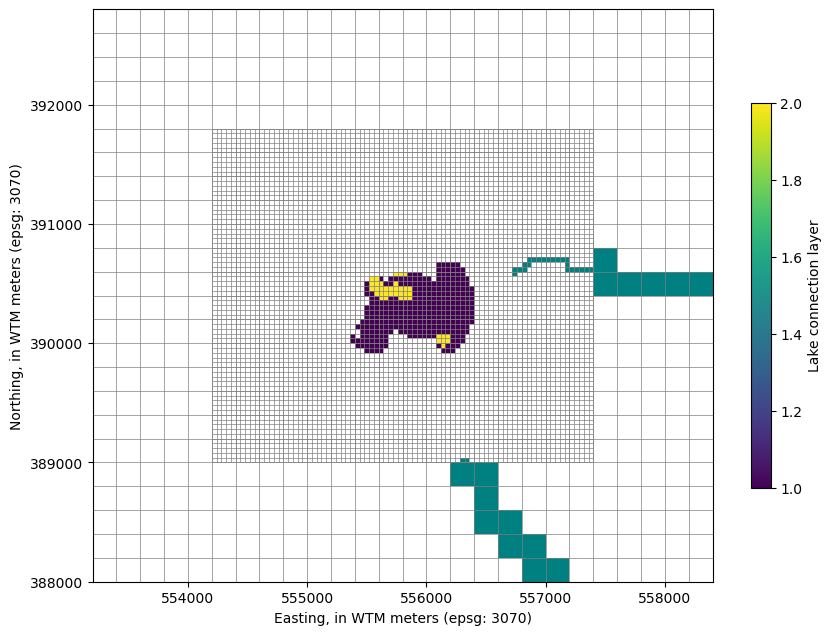

In [13]:
inset = m.inset['plsnt-lgr-inset']

# Get the parent model grid extent
# to set plot limits later
l, r, b, t = m.modelgrid.extent

# Make the plot
fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax)
parent_mv.plot_bc("SFR", plotAll=True)
inset_mv.plot_bc("SFR", plotAll=True)
lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)

# Get the lake connections
vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = zip(*vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))
lakeconnections[i, j] = np.array(k)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = inset_mv.plot_array(lakeconnections)

# re-limit the plot to the parent model extent
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi, shrink=0.5, label='Lake connection layer')
ax.set_xlabel('Easting, in WTM meters (epsg: 3070)')
ax.set_ylabel('Northing, in WTM meters (epsg: 3070)')

### write the MODFLOW input files
(just like you would for a Flopy model)

In [14]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package pleasant-lgr.mvr...
  writing package pleasant-lgr.gwfgwf...
  writing model plsnt-lgr-parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package oc...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 247 based on size of stress_period_data
    writing package obs_0...
    writing package sfr_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 5 based on size of stress_period_data
    writing package obs_1...
    writing package obs_2...
  writing model plsnt-lgr-inset...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    

### Run the model

**Note:** Running the model through Flopy (as below) requires specification of the MODFLOW executable. In Flopy, the executable is specified via the ``exe_name`` argument to the simulation constructor for MODFLOW 6, or model constructor for previous MODFLOW versions. Similarly, in Modflow-setup, the ``exe_name`` is specified in the ``simulation:`` or ``model:`` block of the [configuration file](https://doi-usgs.github.io/modflow-setup/latest/config-file-gallery.html#pleasant-lake-test-case). This example assumes that a MODFLOW 6 executable with the name "mf6" either resides in the model workspace, or is included in the system path.

In [15]:
m.simulation.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../software/modflow_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:34:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor 

(True, [])

### Plot the results


In [16]:
Path.cwd()

PosixPath('/Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data/pleasant-lgr')

#### Read the output and post-process the 3D head results into 2D water table(s)

In [17]:
import flopy.utils.binaryfile as bf
from flopy.utils.postprocessing import get_water_table

lgr_parent_headsobj = bf.HeadFile('plsnt-lgr-parent.hds')
lgr_inset_headsobj = bf.HeadFile('plsnt-lgr-inset.hds')

# read the head results for the last stress period
kper = 12
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, kper))
lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, kper))

# Get the water table elevation from the 3D head results
inset_wt = get_water_table(lgr_inset_hds)
parent_wt = get_water_table(lgr_parent_hds)

# put in the lake level (not included in head output)
lake_results = pd.read_csv('lake1.obs.csv')
stage = lake_results['STAGE'][kper]
inset_wt[inset.lakarr[0] == 1] = stage

# get the cell budget using the .output attribute
# (instead of the binaryfile utility directly)
cbc = m.output.budget()
inset_cbc = inset.output.budget()
lak = inset_cbc.get_data(text='lak', full3D=True)[0].sum(axis=0)
parent_sfr = cbc.get_data(text='sfr', full3D=True)[0]
inset_sfr = inset_cbc.get_data(text='sfr', full3D=True)[0]

#### Then combine the parent and inset model head results
(into a single grid at the inset model resolution; for a nicer looking plot)

Note: We could skip this step and simply work with the parent and inset models individually in the same plot (as we are doing below with the grids and boundary conditions). However, if we want to create continuous contours of the head solution, we need to first resample it to a single grid (usually at the finer inset model resolution) that spans the whole model domain. 

In [18]:
# make the single grid
l, b, r, t = m.modelgrid.bounds
xi = np.arange(l, r, 40)
yi = np.arange(b, t, 40)[::-1]
Xi, Yi = np.meshgrid(xi, yi)

# make a single set of points
# including both parent and inset cell centers
# and water table values
x = m.modelgrid.xcellcenters[~parent_wt.mask]
y = m.modelgrid.ycellcenters[~parent_wt.mask]
x = np.append(x, inset.modelgrid.xcellcenters[~inset_wt.mask])
y = np.append(y, inset.modelgrid.ycellcenters[~inset_wt.mask])
z = parent_wt[~parent_wt.mask].data
z = np.append(z, inset_wt[~inset_wt.mask].data)

# interpolate the results from the points
# onto the single inset resolution grid
results = griddata((x, y), z, (Xi, Yi))

### Make the plot
* include the parent and inset model grids
* show the head contours for the combined parent/inset simulation
* show "leakage" results for the Lake and SFR packages (neg. values indicate groundwater discharge to surface water)

Note: Leakage (cell by cell flow) reported by MODFLOW is volumetric, so the apparent parent model values will be higher, simply because they contain more length of stream than the inset model cells.

Text(0.5, 0, 'Easting, in Wisconsin Transverse Mercator (meters)')

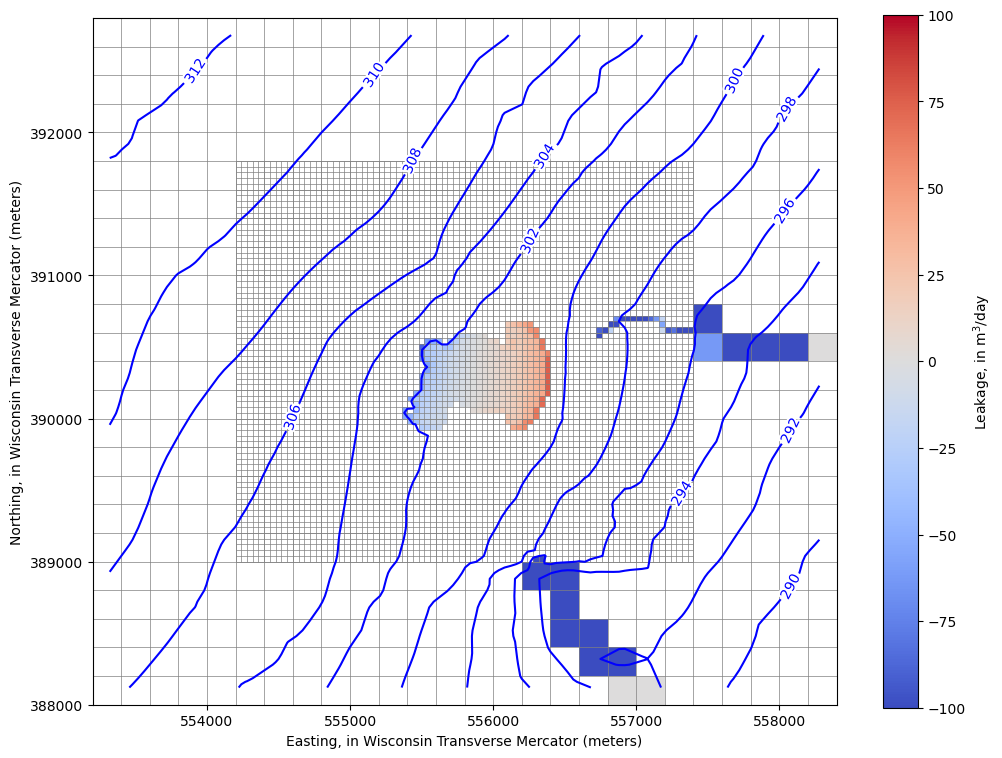

In [19]:
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

layer = 0
fig, ax = plt.subplots(figsize=(12, 12))
# create Flopy plot objects
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

vmin, vmax = -100, 100
parent_mv.plot_array(parent_sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
im = inset_mv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = inset_mv.plot_array(inset_sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.75, label='Leakage, in m$^3$/day')

# contour the combined inset/parent head results
levels = np.arange(290, 315, 2)
ctr = ax.contour(Xi, Yi, results, levels=levels, colors='b', zorder=10)
labels = ax.clabel(ctr, inline=True, fontsize=10, inline_spacing=20)
plt.setp(labels, path_effects=[
    patheffects.withStroke(linewidth=3, foreground="w")])

# plot the grid cell edges
lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)

ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
ax.set_ylabel('Northing, in Wisconsin Transverse Mercator (meters)')
ax.set_xlabel('Easting, in Wisconsin Transverse Mercator (meters)')



#### References
Fienen, M. N., Haserodt, M. J., Leaf, A. T., and Westenbroek, S. M. (2022). Simulation of regional groundwater flow and groundwater/lake interactions in the central Sands, Wisconsin. U.S. Geological Survey Scientific Investigations Report 2022-5046. doi:10.3133/sir20225046

Leaf, A.T. and Fienen, M.N. (2022) Modflow-setup: Robust automation of groundwater model construction. Front. Earth Sci. 10:903965. doi: 10.3389/feart.2022.903965

Westenbroek, S. M., Engott, J. A., Kelson, V. A., and Hunt, R. J. (2018). SWB Version 2.0—a soil-water-balance code for estimating net infiltration and other 1152 water-budget components. U.S. Geological Survey Techniques and Methods, book 6,
118. chap. A59. doi:10.3133/tm6A59

White, J. T., Hemmings, B., Fienen, M. N., and Knowling, M. J. (2021). Towards improved environmental modeling outcomes: Enabling low-cost access to high- 1157 dimensional, geostatistical-based decision-support analyses. Environ. Model. Softw.
139, 105022. doi:10.1016/j.envsoft.2021.105022

Wisconsin Department of Natural Resources (WDNR) (2021). Central Sands Lake study report: Findings and recommendations. Rep. Wis. State Legislature. 1162 doi:10.5281/zenodo.5708791